In [1]:
import numpy as np
import scipy.integrate as sp_int
%matplotlib inline
import sys
sys.path.append('../')
import analytical_tools.functions as analytics
# Then OPTIONAL code (just for graphical display, all those functions can be removed)
sys.path.append('../../common_libraries/') # https://bitbucket.org/yzerlaut/common_libraries
from graphs.my_graph import set_plot, put_list_of_figs_to_svg_fig

In [2]:
## theoretical expressions : probability density and first passage time, see Equation 29

def fluct_prop(nu_e, nu_i,\
               Je=1e-12, Ji=1e-12, Ne=1000, Ni=250, Cm=200e-12, Gl=10e-9,\
               El=-70e-3, Vthre=-50e-3, Vreset=-70e-3):
    Tv = Cm/Gl
    muV = El+(nu_e*Ne*Je+nu_i*Ni*Ji)*Tv/Gl
    sV = np.sqrt(Je**2*nu_e*Ne+Ji**2*nu_i)*np.sqrt(Tv/2.)/Gl
    return muV, sV, Tv

def FPT_LIF_function(nu_e, nu_i,\
               Je=1e-12, Ji=1e-12, Ne=1000, Ni=250, Cm=200e-12, Gl=10e-9,\
               El=-70e-3, Vthre=-50e-3, Vreset=-60e-3, Trefrac=2e-3):
    muV, sV, Tv = fluct_prop(nu_e, nu_i, Je, Ji, Ne, Ni, Cm, Gl, El, Vthre, Vreset)
    return analytics.FPT_function(muV, sV, Tv, Vthre, Vreset, Trefrac)

def Proba_distrib(v, nu_e, nu_i,\
                   Je=1e-12, Ji=1e-12, Ne=1000, Ni=250, Cm=200e-12, Gl=10e-9,\
                   El=-70e-3, Vthre=-50e-3, Vreset=-60e-3, Trefrac=2e-3):
    muV, sV, Tv = fluct_prop(nu_e, nu_i, Je, Ji, Ne, Ni, Cm, Gl, El, Vthre, Vreset)
    def rescale(vvv):
        return (vvv-muV)/np.sqrt(2)/sV
    def exp_square(y):
        return np.exp(y**2)
    nu_out = FPT_LIF_function(nu_e, nu_i, Je, Ji, Ne, Ni, Cm, Gl, El, Vthre, Vreset, Trefrac)
    low_bound = np.amax([v,Vreset])
    integral = sp_int.quad(exp_square, rescale(low_bound), rescale(Vthre))
    return 2*nu_out/sV/np.sqrt(2)*np.exp(-rescale(v)**2)*integral[0]

def print_params(p):
    return """
    $J_e$=%(Je)s, $J_i$=%(Ji)s, (SI units)
    $N_e$=%(Ne)i, $N_i$=%(Ni)i, 
    $C_m$=%(Cm)s, $G_L$=%(Gl)s, 
    $E_L$=%(El)s, $V_{reset}$=%(Vreset)s, $V_{thre}$=%(Vthre)s
    """ % p

In [3]:
params = {'Cm':200e-12, 'Gl':10e-9,         
          'Je' :4e-12, 'Ji': -7e-12, # pA, X*1e11-> X mV depol for 10 nS
          'Ne':1000, 'Ni':250,
          'Vthre':-50e-3, 'El':-70e-3,\
          'Vreset':-70e-3, 'Trefrac':2e-3}

vv = np.linspace(-71e-3, -50e-3, 5e2)

PDF, NU = [], []
NU0 = [3.5, 4.3, 5.1, 6.]
NuI = 6.
for nu_in in NU0:
    pdf = np.zeros(vv.size)
    for iv in range(vv.size):
        pdf[iv] = Proba_distrib(vv[iv], nu_in, NuI, **params) 
    PDF.append(pdf)
    NU.append(FPT_LIF_function(nu_in, NuI, **params))

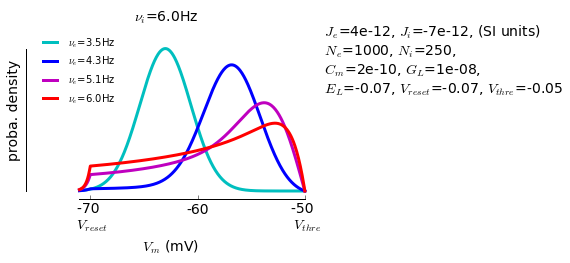

In [4]:
fig, ax = plt.subplots(figsize=(5,3))
fig.suptitle("$\\nu_{i}$="+str(NuI)+'Hz')
plt.annotate(print_params(params), (.99, .5), xycoords='axes fraction')
for nu_in, pdf, col in zip(NU0, PDF, ['c', 'b', 'm', 'r']):
    ax.plot(1e3*vv, pdf/np.sum(pdf), color=col, lw=3, label="$\\nu_{e}$="+str(nu_in)+'Hz')
ax.legend(frameon=False, loc='upper left',prop={'size':10})#,bbox_to_anchor = (0.1, 0.92))
set_plot(ax, xlabel="$V_m$ (mV)", ylabel="proba. density", yticks=[], xticks=[-70, -60, -50],\
        xticks_labels=['-70 \n $V_{reset}$', '-60', '-50 \n $V_{thre}$'])

In [5]:
## Numerical simulations of the excitatory delta-synapse case

def SingleSimulation(nu_e, nu_i, seed=2, Nevents=1e5,\
                       Je=1e-12, Ji=-1e-12, Ne=1000, Ni=250, Cm=200e-12, Gl=10e-9,\
                       El=-70e-3, Vthre=-50e-3, Vreset=-70e-3, Trefrac=2e-3): # one simulation for a given frequency of input
    np.random.seed(seed)
    # preparing presynaptic events
    if (nu_e>0) and (Ne>0):
        spks_exc = np.cumsum(np.random.exponential(1./nu_e/Ne, Nevents))
    else:
        spks_exc = []
    if (nu_i>0) and (Ne>0):
        spks_inh = np.cumsum(np.random.exponential(1./nu_i/Ni, Nevents))
    else:
        spks_inh = []
    spks = np.concatenate([spks_exc, spks_inh]) # all excitatory and inhibibtory events
    weights = np.concatenate([np.ones(len(spks_exc))*Je,np.ones(len(spks_inh))*Ji])
    weights = weights[spks<min([spks_exc.max(),spks_inh.max()])] # else biased toward one or the other
    spks = spks[spks<min([spks_exc.max(),spks_inh.max()])] # else biased toward one or the other
    isort = np.argsort(spks)
    spks, weights = spks[isort], weights[isort]
    # now simulation
    counter_spk = 0 # spike counter
    v = Vreset # membrane potential at last pre-syn event
    t = spks[0] # starting at the first spike
    t_last_spk = spks[0]
    for w, spk in zip(weights[:-1], spks[1:]):
        # we start by testing the effect of the last spike
        # did this last event could trigger a spike ??
        if (t-t_last_spk)>=Trefrac:
            v+=w/Gl
        if v>Vthre :
            # it triggers a spike
            v = Vreset
            counter_spk +=1
            t_last_spk = t
            
        v = El+(v-El)*np.exp(-(spk-t)/Cm*Gl) # value at future spike
        t=spk
    return counter_spk/t

In [6]:
# Comparison with numerical simulations
DISCRET = 30
nu, fr = np.array([(f, SingleSimulation(f, NuI, **params)) for f in np.linspace(1, 8, DISCRET)]).T
nu_th, fr_th = np.array([(f, FPT_LIF_function(f, NuI, **params)) for f in np.linspace(1, 8, DISCRET)]).T

/Users/yzerlaut/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/yzerlaut/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


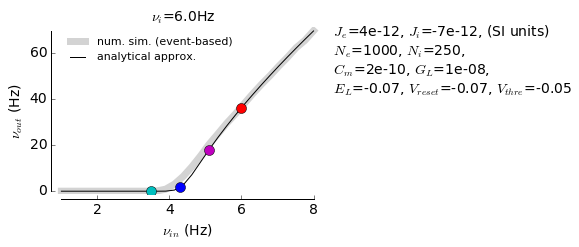

In [7]:
fig, ax = plt.subplots(1, figsize=(4.7,3))
fig.suptitle("$\\nu_{i}$="+str(NuI)+'Hz')
plt.annotate(print_params(params), (.99, .5), xycoords='axes fraction')
plt.plot(nu, fr, color='lightgray', lw=7, label='num. sim. (event-based)')
plt.plot(nu_th, fr_th, 'k-', label='analytical approx.')
plt.legend(loc='upper left',frameon=False,prop={'size':11})
for nu_in, nu_out, col in zip(NU0, NU, ['c', 'b', 'm', 'r']):
    ax.plot(nu_in, nu_out, 'o', color=col, ms=10)
set_plot(ax, xlabel='$\\nu_{in}$ (Hz)', ylabel='$\\nu_{out}$ (Hz)')

In [8]:
sys.path.append('../numerical_simulations/')
from LIF_delta_current_synapses import run_sim

In [9]:
dt, tstop = 5e-2, 500.
V = []
for nu_in in NU0:
    print('===> Simulation, Fe=', nu_in)
    V.append(run_sim(nu_in, NuI, params, dt=dt, tstop=tstop, SEEDS=1, with_trace=True))

===> Simulation, Fe= 3.5
[...] Initialisation 
[...] Running simulation
 Done !
===> Simulation, Fe= 4.3
[...] Initialisation 
[...] Running simulation
 Done !
===> Simulation, Fe= 5.1
[...] Initialisation 
/!\ Warning /!\ 
Temporal discretization might not be sufficient !
One spike every : 3  bins
[...] Running simulation
 Done !
===> Simulation, Fe= 6.0
[...] Initialisation 
/!\ Warning /!\ 
Temporal discretization might not be sufficient !
One spike every : 3  bins
[...] Running simulation
 Done !


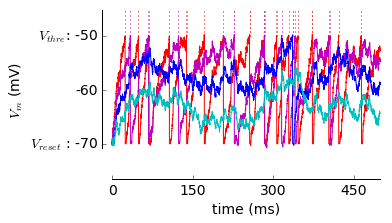

In [10]:
t = np.arange(int(tstop/dt)-1)*dt
fig, ax = plt.subplots(figsize=(5,3))
for v, col in zip(V[::-1], ['c', 'b', 'm', 'r'][::-1]):
    ax.plot(t, 1e3*v, color=col)
    for ispk in np.argwhere(1e3*np.array(v)>-50):
        ax.plot([t[ispk],t[ispk]], [-50,-45], ':', color=col)
set_plot(ax, ylabel="$V_m$ (mV)", xlabel="time (ms)", yticks=[-70, -60, -50],\
                yticks_labels=['$V_{reset}$ : -70', '-60', '$V_{thre}$: -50'])

In [13]:
dt, tstop = 1e-2, 10000.
NU0 = np.linspace(2, 8, 2)
F, sF = 0*NU0, 0*NU0
for i in range(len(NU0)):
    F[i], sF[i] = run_sim(NU0[i], NuI, params, dt=dt, tstop=tstop, SEEDS=5, verbose=False)

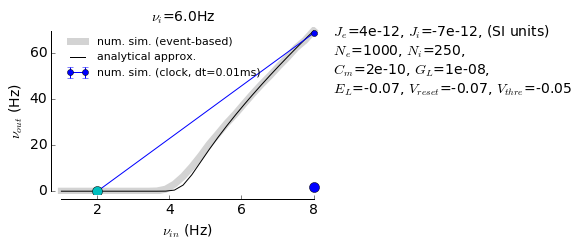

In [15]:
fig, ax = plt.subplots(1, figsize=(4.7,3))
fig.suptitle("$\\nu_{i}$="+str(NuI)+'Hz')
plt.annotate(print_params(params), (.99, .5), xycoords='axes fraction')
plt.plot(nu, fr, color='lightgray', lw=7, label='num. sim. (event-based)')
plt.plot(nu_th, fr_th, 'k-', label='analytical approx.')
ax.errorbar(NU0, F, yerr=sF, fmt='-o', label='num. sim. (clock, dt=0.01ms)')
plt.legend(loc='upper left',frameon=False,prop={'size':11})
for nu_in, nu_out, col in zip(NU0, NU, ['c', 'b', 'm', 'r']):
    ax.plot(nu_in, nu_out, 'o', color=col, ms=10)
set_plot(ax, xlabel='$\\nu_{in}$ (Hz)', ylabel='$\\nu_{out}$ (Hz)')